Create compression version of GPT-2 model and save the memory =)

# Transformer-based model compression tutorial

Seminar prepared by Vika Chekalina

In this notebook we will go through the process of GPT-2 compression.

## Brief reminder: 

### Why do we need GPT-2 compression?

- To reduce disk space consumption
- To accelerate model inference
- To reduce energy consumption

### GPT-2 compression pipeline

1) Extract fully-connected (transformers.conv1D()) from pretrained GPT-2

2) Decompose it with linear algebra decomposition method

3) Replace initial fully-connected layer with factorized layer

4) Fine-tune model to recover performance degradation


## Let's go through all of the stages in the pipeline

In [ ]:
device = 'cuda'

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 11.6 MB/s 
     |████████████████████████████████| 6.6 MB 9.5 MB/s 
     |████████████████████████████████| 596 kB 11.9 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config()

# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Count parameters number

In [ ]:
print ("num parameters in model", model.num_parameters()) #124 mln

num parameters in model 124439808


We will validate a pre-trained language GPT-2 model on a validation part **Wikitext-103** dataset.

To create a validation dataset we should:
    
- download archieved dataset
- extract it
- wrap tran and test parts in TextDataset and further Dataloader class

In [ ]:
!pwd
!curl https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip -o wikitext-103-v1.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  181M  100  181M    0     0  89.4M      0  0:00:02  0:00:02 --:--:-- 89.3M


In [ ]:

!unzip wikitext-103-v1.zip
!ls

Archive:  wikitext-103-v1.zip
   creating: wikitext-103/
  inflating: wikitext-103/wiki.test.tokens  
  inflating: wikitext-103/wiki.valid.tokens  
  inflating: wikitext-103/wiki.train.tokens  
sample_data  wikitext-103  wikitext-103-v1.zip


Create a validation dataset and measure perplexity of regular GPT-2

In [ ]:
from torch.utils.data import DataLoader, RandomSampler
from transformers import GPT2Tokenizer
from transformers import TextDataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

    
dataset_valid = TextDataset(tokenizer=tokenizer, 
                                file_path="/content/wikitext-103/wiki.valid.tokens", 
                                block_size=512)
    
dataset_test = TextDataset(tokenizer=tokenizer, 
                                file_path="/content/wikitext-103/wiki.test.tokens", block_size=512)
len(dataset_valid), len(dataset_test)

eval_dataloader = DataLoader(dataset_valid, batch_size=10)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


Validate model and calculate a perplexity:

In [ ]:
from tqdm import tqdm
model.eval()
import torch

def evaluate(model):
    losses = []
    eval_loss = 0.0
    perplexity = 0.0
    nb_eval_steps = 0
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
            perplexity += torch.exp(torch.tensor(eval_loss))
            losses.append(eval_loss)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps

    perplexity = torch.exp(torch.tensor(eval_loss))
    perplexity = perplexity 
    return perplexity

In [ ]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s]


tensor(35.1143)

In [ ]:
model.transformer.h[1].mlp.c_fc.weight.shape

torch.Size([768, 3072])

# Which parts of the transformer are best to compress?

Parameters in the parts of thransormer model, MB:

Part \ Model           | GPT-2 small  |  GPT-2 medium | GPT-2 large
-----------------------|--------------|---------------|---------------|
Attention block        | 9.01         |      16.02    |        25.02  |
MLP block              | 18.01        |      32.02    |     50.02     |

# 2. SVD-compression of Fully Connected layer

Linear layer: $Y = X W^T + b$

Singular Value decomposition: $W = U \Sigma V^T$

We use truncated SVD with rank $r$: $U_r = U[:, :r], \Sigma_r = Σ[:r, :r], V_r = V[:, :r]$

Since $\Sigma_r$ is a diagonal matrix of shape $r \times r$, we can fuze it inside $U_r$ and $V_r$ in order to avoid multiplication of X with it during inference time:

$ W_2 = U[:, :r] \sqrt{\Sigma_r}, W_1 = \sqrt{\Sigma_r} U[:, :r]^T$

As a result, we get:

$W ≈ W_2 W_1$ and $Y \approx X W_1^T W_2^T + b$

Which is equivalent to two sequential linear layers - first with weight $W_1$ and zero bias and the second one with weight $W_2$ and bias $b$.

Let $W$ have $n_{in}, n_{out}$ shape.

Then, FLOP number of initial linear layer is $2 \times n_{in} \times (n_{out} + 1)$.

And FLOP number of factorized layer is $2 \times n_{in} \times r + r \times (2 \times n_{out} + 1). $

If $r < \frac{n_{in} \times (n_{out} + 1)}{n_{in} +  n_{out} + 0.5}$, then complexity of factorized layer is lower.

In [ ]:
fc_w = model.transformer.h[0].mlp.c_fc.weight.data.cpu().data.numpy()
fc_b = model.transformer.h[0].mlp.c_fc.bias.data.cpu().data.numpy()
fc_w.shape, fc_b.shape

((768, 3072), (3072,))

In [ ]:
from transformers.modeling_utils import Conv1D

def factorize_to_svd(fc_w, fc_b, rank):
    U, S, Vt = np.linalg.svd(fc_w, full_matrices=False)
    # truncate SVD and fuse Sigma matrix
    w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
    w2 = np.dot(U[:,0:rank,], np.diag(np.sqrt(S[0:rank])))

    # create new layers and insert weights
    out_features, in_features = fc_w.shape
    is_bias = fc_b is not None 

    linear1 = nn.Linear(in_features = in_features, 
                      out_features = rank,
                      bias = False)
    linear1.weight = nn.Parameter(torch.FloatTensor(w1))

    linear2 = nn.Linear(in_features = rank,
                      out_features = out_features,
                      bias=is_bias)
    linear2.weight = nn.Parameter(torch.FloatTensor(w2))
    linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))

    # create factorized layer
    factorized_layer = nn.Sequential(linear1.to(device),linear2.to(device))
    return factorized_layer

We select a fully-connected layer in the 6th, 8th, 9th, 10th and 11th block of GPT-2. 

Note that Conv1D() Transformer class has transposed weight matrix.





In [ ]:
import torch
from torch import nn
import numpy as np

for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu().data.numpy()
    fc_b = model.transformer.h[i].mlp.c_fc.bias.data.cpu().data.numpy()
    print (fc_w.shape, fc_b.shape)
    factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = 50)
    model.transformer.h[i].mlp.c_fc = factorized_layer
    
    fc_w = model.transformer.h[i].mlp.c_proj.weight.data.cpu().data.numpy()
    fc_b = model.transformer.h[i].mlp.c_proj.bias.data.cpu().data.numpy()
    print (fc_w.shape, fc_b.shape)
    factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = 50)
    model.transformer.h[i].mlp.c_proj = factorized_layer
    

(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)
(768, 3072) (3072,)
(3072, 768) (768,)


In [ ]:
print ("num parameters in model", model.num_parameters())

num parameters in model 102766848


In [ ]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 49/49 [00:19<00:00,  2.45it/s]


tensor(121.1321)

Let's define a function that will iterate over the compression ratios of a fully connected layer, 

apply the selected compression to the selected layers,

and calculate the resulting perplexity**

In [ ]:
def evaluate_compression_and_ppx(rank = 50, layer_to_remove = [6, 8, 9, 10, 11]):
    configuration = GPT2Config()
    # Initializing a model from the configuration
    model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
    outt = model.to(device)
    print ("rank", rank)
    print ("layers", layer_to_remove)
    for i in layer_to_remove:
    # fc part
        fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu()
        fc_b = model.transformer.h[i].mlp.c_fc.bias.data.cpu().data.numpy()
        factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = rank)
        model.transformer.h[i].mlp.c_fc = factorized_layer.to(device)
        
        fc_w = model.transformer.h[i].mlp.c_proj.weight.data.cpu().data.numpy()
        fc_b = model.transformer.h[i].mlp.c_proj.bias.data.cpu().data.numpy()
        print (fc_w.shape, fc_b.shape)
        factorized_layer = factorize_to_svd(np.transpose(fc_w), fc_b, rank = rank)
        model.transformer.h[i].mlp.c_proj = factorized_layer.to(device)
    print ("num parameters in model", model.num_parameters()) 
    perplexity = evaluate(model)
    print ("perplexity", perplexity)

In [ ]:
for rank in [50, 100, 200, 300, 400, 500]:
    evaluate_compression_and_ppx(rank = rank, layer_to_remove = [6, 8, 9, 10, 11])

rank 50
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 102766848


Evaluating: 100%|██████████| 49/49 [00:20<00:00,  2.42it/s]


perplexity tensor(121.1321)
rank 100
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 104686848


Evaluating: 100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


perplexity tensor(103.6401)
rank 200
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 108526848


Evaluating: 100%|██████████| 49/49 [00:21<00:00,  2.28it/s]


perplexity tensor(74.4626)
rank 300
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 112366848


Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s]


perplexity tensor(59.4694)
rank 400
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 116206848


Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.15it/s]


perplexity tensor(49.6767)
rank 500
layers [6, 8, 9, 10, 11]
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
(3072, 768) (768,)
num parameters in model 120046848


Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.11it/s]

perplexity tensor(43.0938)


# Pruning 

To be sure that problems cannot be solved by simply removing layers, 

we replace the weight matrix with random initializations and calculate the final perplexity.

In [ ]:
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)

In [ ]:
for i in [6, 8, 9, 10, 11]:
    # fc part
    fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu().data.numpy()
    fp_w = model.transformer.h[i].mlp.c_proj.weight.data.cpu().data.numpy()
    model.transformer.h[i].mlp.c_fc = Conv1D(nx = fc_w.shape[0], nf = 2600)
    model.transformer.h[i].mlp.c_proj = Conv1D(nx = 2600, nf = fc_w.shape[0])

In [ ]:
print ("num parameters in model", model.num_parameters())

num parameters in model 120812488


In [ ]:
perplexity = evaluate(model.to(device))
perplexity

Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.13it/s]


tensor(119.0928)

This is much more than in the pre-trained and in compressed model!

# Tucker decomposition of a Fully-connected layer

In [ ]:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config()

# Initializing a model from the configuration
model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
outt = model.to(device)

To apply Tucker Decomposition:

- We represent fully-connected layer as a 1D -convolutional with filter of size 1.
- Apply Partial-Tucker decomposition (Tucker decomposition over along some selected axes instead of all).
- For decompostion we use open-sourse [Tensorly](http://tensorly.org/stable/index.html) backend.



In [ ]:
!pip3 install tensorly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 28.8 MB/s 
     |████████████████████████████████| 154 kB 67.0 MB/s 


In [ ]:
import tensorly
tensorly.set_backend('pytorch')
import numpy as np
from tensorly.decomposition import tucker, partial_tucker
from tensorly.tenalg import mode_dot

def tucker_decomposition_conv_layer(weight, bias, rank, device):
    """ Gets a conv layer, 
        returns a list of products of the Tucker decomposition.
    """

    
    core, [last, first] = \
        partial_tucker(weight.data, \
            modes=[0,1], rank=rank, init='svd')
    
    first_layer = torch.nn.Conv1d(in_channels=first.shape[0], \
            out_channels=first.shape[1], kernel_size=1)
    
    core_layer = torch.nn.Conv1d(in_channels=core.shape[1], \
            out_channels=core.shape[0], kernel_size=1)
    
    last_layer = torch.nn.Conv1d(in_channels=last.shape[1], \
        out_channels=last.shape[0], kernel_size=1)
    
    last_layer.bias.data = bias.data

    first_layer.weight.data = \
        torch.transpose(first, 1, 0).unsqueeze(-1)
    last_layer.weight.data = last.unsqueeze(-1)
    core_layer.weight.data = core

    new_layers = [first_layer.to(device), core_layer.to(device), last_layer.to(device)]
    return new_layers

In [ ]:
import torch
from torch import nn
import numpy as np

In [ ]:
class TuckerLinear(nn.Module):
    def __init__(self, fc_w, fc_b, rank):
        super().__init__()

        self.first_layer, self.core_layer, self.last_layer = tucker_decomposition_conv_layer(torch.transpose(fc_w, 0, 1).unsqueeze(2), fc_b, rank = rank, device=device)
        self.first_layer.to(device)
        self.core_layer.to(device)
        self.last_layer.to(device)

    def forward(self, x):
        x3 = self.first_layer(x.transpose(1, 2))
        x3 = self.core_layer(x3.transpose(2, 0))
        x3 = self.last_layer(x3.transpose(2, 0))
       
        #x3 = self.core_layer(x3.transpose(2, 0))
        
        return (x3.transpose(1, 2).contiguous())





In [ ]:
rank = [360, 360]
for i in [6, 8, 9, 10, 11]:
    fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu()
    fc_b = model.transformer.h[i].mlp.c_fc.bias
    factorized_layer = TuckerLinear(fc_w, fc_b, rank = rank).to(device)
    model.transformer.h[i].mlp.c_fc = factorized_layer
    

/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


What happens?

$W \in [768, 3072] ⇒ [768, 360], [360, 360], [360, 3072]$

How does **Forward** go?

Input $\in [10, 512, 768] \overset{transpose}{\Rightarrow} [10, 768, 512] \overset{first}{\Rightarrow} [10, 360, 512]  \overset{transpose}{\Rightarrow} [512, 360, 10] \overset{core}{\Rightarrow} [512, 360, 10] \overset{transpose}{\Rightarrow} [10, 360, 512] \overset{last}{\Rightarrow} [10, 3072, 512] \overset{transpose}{\Rightarrow} [10, 512, 3072] $


**first** $\in [360, 768, 1]$, 

**core** $\in [360, 360, 1]$, 

**last** $\in [3072, 360, 1]$


In [ ]:
perplexity = evaluate(model)
perplexity

Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s]


tensor(50.0712)

In [ ]:
params = []
perplext = []
def evaluate_compression_and_ppx(rank = [120, 100], layer_to_remove = [8, 10]):
    configuration = GPT2Config()
    # Initializing a model from the configuration
    model = GPT2LMHeadModel(configuration).from_pretrained("gpt2",
                                                return_dict=True,
                                                is_decoder=True)
    outt = model.to(device)
    print ("rank", rank)
    print ("layers", layer_to_remove)
    for i in layer_to_remove:
    # fc part
        fc_w = model.transformer.h[i].mlp.c_fc.weight.data.cpu()
        fc_b = model.transformer.h[i].mlp.c_fc.bias
        factorized_layer = TuckerLinear(fc_w, fc_b, rank = rank).to(device)
        model.transformer.h[i].mlp.c_fc = factorized_layer
        
    print ("num parameters in model", model.num_parameters()) 
    params.append(model.num_parameters())
    perplexity = evaluate(model)
    print ("perplexity", perplexity)
    perplext.append(perplexity)

In [ ]:
for rank in [[150, 130], [190, 150], [250, 300], [300, 300], [350, 350], [370, 360], [370, 370]]:
    evaluate_compression_and_ppx(rank = rank, layer_to_remove = [6, 8, 9, 10, 11])

rank [150, 130]
layers [6, 8, 9, 10, 11]


/usr/local/lib/python3.7/dist-packages/tensorly/backend/core.py:1106: UserWarning: In partial_svd: converting to NumPy. Check SVD_FUNS for available alternatives if you want to avoid this.
  warnings.warn('In partial_svd: converting to NumPy.'


num parameters in model 115545428


Evaluating: 100%|██████████| 49/49 [00:21<00:00,  2.24it/s]


perplexity tensor(91.8104)
rank [190, 150]
layers [6, 8, 9, 10, 11]
num parameters in model 116281928


Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


perplexity tensor(86.0878)
rank [250, 300]
layers [6, 8, 9, 10, 11]
num parameters in model 118013078


Evaluating: 100%|██████████| 49/49 [00:22<00:00,  2.13it/s]


perplexity tensor(61.7284)
rank [300, 300]
layers [6, 8, 9, 10, 11]
num parameters in model 118856328


Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.10it/s]


perplexity tensor(54.8872)
rank [350, 350]
layers [6, 8, 9, 10, 11]
num parameters in model 119979328


Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s]


perplexity tensor(50.2341)
rank [370, 360]
layers [6, 8, 9, 10, 11]
num parameters in model 120378578


Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s]


perplexity tensor(50.0760)
rank [370, 370]
layers [6, 8, 9, 10, 11]
num parameters in model 120435528


Evaluating: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s]

perplexity tensor(48.6838)


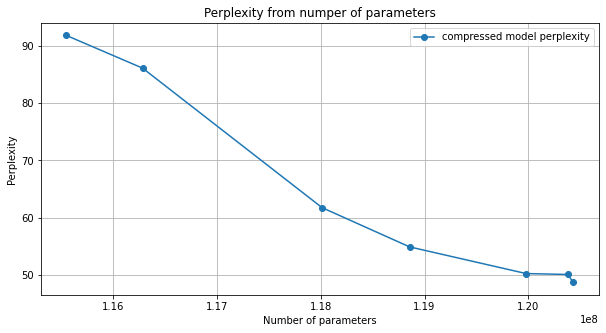

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(params, perplext, marker = 'o', label="compressed model perplexity")
plt.grid()
plt.title("Perplexity from numper of parameters")
plt.xlabel("Number of parameters")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

## Fine-Tune (Bonus)

In [ ]:
dataset_train = TextDataset(tokenizer=tokenizer, 
                                file_path="/home/jovyan/greenAI_gpt/wikitext-103/wiki.train.tokens", block_size=512)

train_dataloader = DataLoader(dataset_train, batch_size=10)

In [ ]:
from transformers import get_cosine_schedule_with_warmup

In [ ]:
epochs = 10
gradient_accumulation_steps = 12
num_train_batches = len(train_dataloader)
cross_entropy = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.eos_token_id)
training_steps = num_train_batches // gradient_accumulation_steps * epochs
optimizer = torch.optim.Adam(model.parameters(), lr=6.25e-5)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=800, num_training_steps=training_steps)


for epoch in range(1, 10):
    
    train_loss = 0
    epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=True)
    for train_batch_idx, item in enumerate(epoch_iterator):
        optimizer.zero_grad() # in case there are unused accumulated gradients
        
        model.train()
        src, tgt = (item, item)
        src = src.to(device=device)
        tgt = tgt.to(device=device)

    
        output = model(input_ids=src, labels=tgt)
        loss = output.loss
        train_loss += loss.item() # before gradient accumulation step
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward() # accumulate gradients
            
        if train_batch_idx % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            optimizer.zero_grad()
            
        if train_batch_idx % 1000 == 0:
            print ("loss", loss)
            perplexity = evaluate(model)
            print ("perplexity", perplexity)
                    